# 第7部　正則化｜Pythonで学ぶ統計学入門

## 3章　PythonによるRidge回帰・Lasso回帰

### 分析の準備

In [2]:
# 数値計算に使うライブラリ
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

# グラフを描画するライブラリ
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

# 統計モデルを推定するライブラリ(ワーニングが出ることもあります)
import statsmodels.formula.api as smf
import statsmodels.api as sm

# 機械学習法を適用するためのライブラリ
from sklearn import linear_model

# 表示桁数の指定
%precision 3
# グラフをjupyter Notebook内に表示させるための指定
%matplotlib inline

In [3]:
# ファイルからのデータ読み込み
X = pd.read_csv("7-3-1-large-data.csv")
X.head(3)

X_1     X_2     X_3     X_4     X_5     X_6     X_7     X_8     X_9  \
0  1.0000  0.5000  0.3333  0.2500  0.2000  0.1667  0.1429  0.1250  0.1111   
1  0.5000  0.3333  0.2500  0.2000  0.1667  0.1429  0.1250  0.1111  0.1000   
2  0.3333  0.2500  0.2000  0.1667  0.1429  0.1250  0.1111  0.1000  0.0909   

     X_10   ...      X_91    X_92    X_93    X_94    X_95    X_96    X_97  \
0  0.1000   ...    0.0110  0.0109  0.0108  0.0106  0.0105  0.0104  0.0103   
1  0.0909   ...    0.0109  0.0108  0.0106  0.0105  0.0104  0.0103  0.0102   
2  0.0833   ...    0.0108  0.0106  0.0105  0.0104  0.0103  0.0102  0.0101   

     X_98    X_99   X_100  
0  0.0102  0.0101  0.0100  
1  0.0101  0.0100  0.0099  
2  0.0100  0.0099  0.0098  

[3 rows x 100 columns]

### 実装：標準化

In [4]:
# X_1の平均値
sp.mean(X.X_1)

0.037

In [5]:
# すべての説明変数の平均値
sp.mean(X, axis = 0).head(3)

X_1    0.037272
X_2    0.030649
X_3    0.027360
dtype: float64

In [6]:
# 標準化
X -= sp.mean(X, axis = 0)
X /= sp.std(X, ddof = 1, axis = 0)

In [7]:
# 確認
sp.mean(X, axis = 0).head(3).round(3)

X_1    0.0
X_2   -0.0
X_3   -0.0
dtype: float64

In [8]:
# 確認
sp.std(X, ddof = 1, axis = 0).head(3)

X_1    1.0
X_2    1.0
X_3    1.0
dtype: float64

### シミュレーションで応答変数を作る

In [9]:
# 応答変数を作る

# 正規分布に従うノイズ
np.random.seed(1)
noise =  sp.stats.norm.rvs(loc = 0, scale = 1, size = X.shape[0])

# 正しい係数は5として応答変数を作る
y =  X.X_1 * 5 + noise

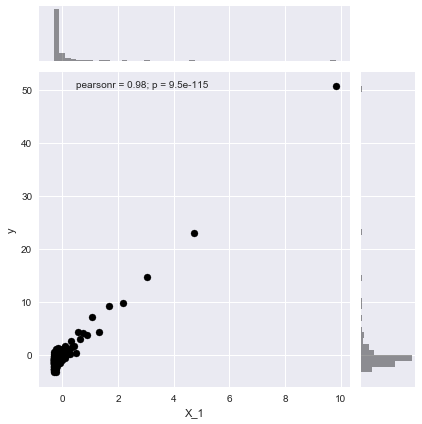

In [10]:
# 応答変数と説明変数をまとめる
large_data = pd.concat([pd.DataFrame({"y":y}), X], axis = 1)
# 散布図の作成
sns.jointplot(y = "y", x = "X_1", data = large_data,
              color = 'black')

### 実装：普通の最小二乗法を適用する

In [11]:
lm_statsmodels = sm.OLS(endog = y, exog = X).fit()
lm_statsmodels.params.head(3)

X_1     14.755018
X_2    -87.462851
X_3    211.743136
dtype: float64

### 実装：sklearnによる線形回帰

In [12]:
# どんなモデルを作るかをまずは指定
lm_sklearn = linear_model.LinearRegression()
# データを指定して、モデルを推定
lm_sklearn.fit(X, y)
# 推定されたパラメタ(array型)
lm_sklearn.coef_

array([  1.476e+01,  -8.746e+01,   2.117e+02,  -9.415e+01,  -6.817e+01,
        -9.284e+01,   1.761e+00,   8.170e+01,   6.680e+01,   2.788e+01,
        -3.288e+01,   6.818e+01,  -1.699e+01,   2.208e+01,  -4.855e+01,
        -3.390e+01,  -4.536e+01,   9.728e+00,   2.481e+01,   1.858e+00,
         1.599e+00,  -2.838e+01,   6.477e+00,  -5.980e+01,   3.532e+01,
        -1.302e+01,   4.108e+01,  -4.303e+01,   5.247e+01,   1.920e+00,
         3.342e+01,   8.490e+00,   8.329e+00,  -2.293e+01,  -3.577e+01,
        -1.337e+01,   3.178e+01,  -2.018e+01,  -2.654e+01,  -3.523e+01,
         1.927e+01,   4.823e+01,  -1.655e+00,   5.749e-01,  -1.893e+01,
         7.370e-01,   1.047e+01,  -7.732e+00,  -1.854e+00,  -2.559e-01,
        -5.045e+00,  -4.227e+00,   2.523e+01,   1.616e+01,  -1.310e+01,
         6.455e+00,  -1.332e+01,  -2.291e+01,  -1.202e+01,   7.745e+00,
         1.755e+01,   5.997e+00,   4.648e+00,   4.120e+00,  -1.825e+00,
         5.366e+00,   4.546e+00,  -2.598e+00,  -4.091e+00,   7.4

### 実装：Ridge回帰-罰則項の影響

In [13]:
# αを変化させる
n_alphas = 50
ridge_alphas = np.logspace(-2, 0.7, n_alphas)

In [14]:
# 参考
sp.log10(ridge_alphas)

array([-2.   , -1.945, -1.89 , -1.835, -1.78 , -1.724, -1.669, -1.614,
       -1.559, -1.504, -1.449, -1.394, -1.339, -1.284, -1.229, -1.173,
       -1.118, -1.063, -1.008, -0.953, -0.898, -0.843, -0.788, -0.733,
       -0.678, -0.622, -0.567, -0.512, -0.457, -0.402, -0.347, -0.292,
       -0.237, -0.182, -0.127, -0.071, -0.016,  0.039,  0.094,  0.149,
        0.204,  0.259,  0.314,  0.369,  0.424,  0.48 ,  0.535,  0.59 ,
        0.645,  0.7  ])

In [15]:
# αを変えて何度もRidge回帰を実行

# 推定された回帰係数を格納するリスト
ridge_coefs = []
# forループで何度もRidge回帰を推定する
for a in ridge_alphas:
    ridge = linear_model.Ridge(alpha = a, fit_intercept = False)
    ridge.fit(X, y)
    ridge_coefs.append(ridge.coef_)

In [16]:
# アレイに変換
ridge_coefs = np.array(ridge_coefs)
ridge_coefs.shape

(50, 100)

(-8, 10.500)

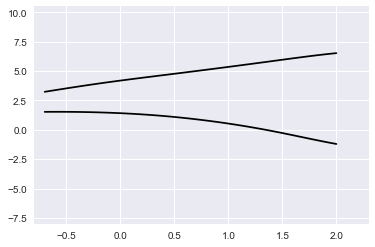

In [17]:
# 参考
log_alphas = -sp.log10(ridge_alphas)
plt.plot(log_alphas, ridge_coefs[::,0], color = 'black')
plt.plot(log_alphas, ridge_coefs[::,1], color = 'black')

plt.xlim([min(log_alphas)-0.1, max(log_alphas) + 0.3])
plt.ylim([-8, 10.5])

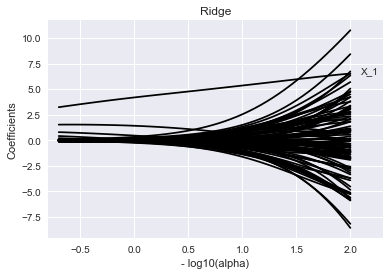

In [18]:
# 横軸に-log10(α)、縦軸に係数を置いた折れ線グラフ
# 100回繰り返さなくても、自動で線を100本引いてくれる

# αを変換
log_alphas = -sp.log10(ridge_alphas)
# 横軸に-log10(α)、縦軸に係数を置いた折れ線グラフ
plt.plot(log_alphas, ridge_coefs, color = 'black')
# 説明変数X_1の係数がわかるように目印を入れる
plt.text(max(log_alphas) + 0.1, np.array(ridge_coefs)[0,0], "X_1")
# X軸の範囲
plt.xlim([min(log_alphas) - 0.1, max(log_alphas) + 0.3])
# 軸ラベル
plt.title("Ridge")
plt.xlabel("- log10(alpha)")
plt.ylabel("Coefficients")

### 実装：Ridge回帰-最適な正則化の強度の決定

In [19]:
# CVで最適なαを求める
ridge_best = linear_model.RidgeCV(
    cv = 10, alphas = ridge_alphas, fit_intercept = False)
ridge_best.fit(X, y) 

# 最適な-log10(α)
-sp.log10(ridge_best.alpha_)

0.237

In [20]:
# 最適なα
ridge_best.alpha_

0.580

In [21]:
# 最適なαの時の、回帰係数
ridge_best.coef_

array([ 4.463,  1.288,  0.293, -0.091, -0.201, -0.233, -0.215, -0.206,
       -0.145, -0.135, -0.155, -0.046, -0.097, -0.017, -0.11 , -0.012,
       -0.094,  0.013, -0.018, -0.031,  0.025, -0.029,  0.043, -0.087,
        0.127,  0.021,  0.055, -0.077,  0.141, -0.007,  0.099,  0.116,
       -0.044,  0.037, -0.034,  0.015,  0.123, -0.171, -0.007, -0.182,
        0.09 ,  0.222,  0.035, -0.032, -0.008,  0.025,  0.338, -0.193,
       -0.108,  0.212, -0.128, -0.246,  0.249,  0.128, -0.155,  0.27 ,
        0.03 , -0.165, -0.178,  0.158, -0.011,  0.013,  0.194,  0.134,
       -0.156, -0.018,  0.256,  0.223, -0.185,  0.006,  0.535,  0.181,
       -0.348, -0.123,  0.226, -0.043, -0.115, -0.053,  0.209,  0.189,
       -0.042, -0.205, -0.099,  0.059, -0.224,  0.15 , -0.039, -0.113,
        0.21 ,  0.012,  0.129, -0.032, -0.022, -0.229, -0.198,  0.245,
       -0.305, -0.396, -0.163,  0.164])

###  実装：Lasso回帰

In [22]:
# αを変えて何度もLasso回帰を実行
lasso_alphas, lasso_coefs, _ = linear_model.lasso_path(
    X, y, fit_intercept = False)

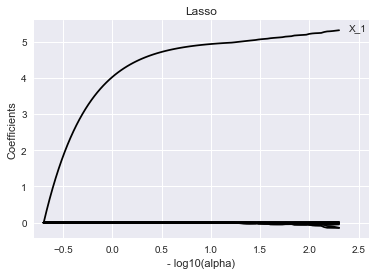

In [23]:
# Lasso回帰のsolution-path

# αを変換
log_alphas = -sp.log10(lasso_alphas)
# 横軸に-log10(α)、縦軸に係数を置いた折れ線グラフ
plt.plot(log_alphas, lasso_coefs.T, color = 'black')
# 説明変数X_1の係数がわかるように目印を入れる
plt.text(max(log_alphas) + 0.1, lasso_coefs[0, -1], "X_1")
# X軸の範囲
plt.xlim([min(log_alphas)-0.1, max(log_alphas) + 0.3])
# 軸ラベル
plt.title("Lasso")
plt.xlabel("- log10(alpha)")
plt.ylabel("Coefficients")

In [39]:
# CVで最適なαを求める
lasso_best = linear_model.LassoCV(
    cv = 10, alphas = lasso_alphas, fit_intercept = False)
lasso_best.fit(X, y)

# 最適な-log(α)
-sp.log10(lasso_best.alpha_)

2.301

In [40]:
# 最適なα
lasso_best.alpha_

0.005

In [41]:
# 最適なαの時の、回帰係数
lasso_best.coef_

array([  5.336e+00,  -0.000e+00,  -0.000e+00,  -3.043e-01,  -4.121e-02,
        -0.000e+00,  -0.000e+00,  -0.000e+00,  -0.000e+00,  -0.000e+00,
        -0.000e+00,  -0.000e+00,  -0.000e+00,  -0.000e+00,  -0.000e+00,
        -0.000e+00,  -0.000e+00,  -0.000e+00,  -0.000e+00,  -0.000e+00,
        -0.000e+00,  -0.000e+00,  -0.000e+00,  -0.000e+00,  -0.000e+00,
        -0.000e+00,  -0.000e+00,  -0.000e+00,   0.000e+00,  -0.000e+00,
         0.000e+00,   0.000e+00,  -0.000e+00,   0.000e+00,   0.000e+00,
         0.000e+00,   0.000e+00,  -0.000e+00,   0.000e+00,   0.000e+00,
         0.000e+00,   0.000e+00,   0.000e+00,   0.000e+00,   0.000e+00,
         0.000e+00,   0.000e+00,   0.000e+00,   0.000e+00,   0.000e+00,
         0.000e+00,   0.000e+00,   0.000e+00,   0.000e+00,   0.000e+00,
         0.000e+00,   0.000e+00,   0.000e+00,   0.000e+00,   0.000e+00,
         0.000e+00,   0.000e+00,   0.000e+00,   0.000e+00,   0.000e+00,
         0.000e+00,   0.000e+00,   0.000e+00,   0.000e+00,   0.0